<a href="https://colab.research.google.com/github/lucas-larsson/II142X/blob/main/II142X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II142X Degree project  VGG16 vs VGG32 a depper dive

- Alex Lindberg : alex5@kth.se
- Lucas LArsson : lulars@kth.se


In [1]:
!nvidia-smi


Tue Apr 16 17:37:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# VGG-16 on Cifar-10

## Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# imports from installed libraries
import os
import numpy as np
import random
import torch
from distutils.version import LooseVersion as Version
from itertools import product


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_deterministic(use_tensorcores=False):
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)

        # The following are set to True by default and allow cards
        # like the Ampere and newer to utilize tensorcores for
        # convolutions and matrix multiplications, which can result
        # in a significant speed-up. However, results may differ compared
        # to card how don't use mixed precision via tensor cores.
        torch.backends.cuda.matmul.allow_tf32 = use_tensorcores
        torch.backends.cudnn.allow_tf32 = use_tensorcores


def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

def calculate_metrics(preds, targets):
    """
    Calculate precision, recall, and F1 score.

    Args:
    - preds: Predictions from the model
    - targets: True labels

    Returns:
    - A dictionary containing the precision, recall, and F1 score
    """
    precision = precision_score(targets, preds, average='macro')
    recall = recall_score(targets, preds, average='macro')
    f1 = f1_score(targets, preds, average='macro')

    return {"precision": precision, "recall": recall, "F1": f1}

def get_all_preds_and_targets(model, data_loader, device):
  all_preds = torch.tensor([]).to(device)
  all_targets = torch.tensor([]).to(device)

  model.eval()
  with torch.no_grad():
      for batch in data_loader:
          images, labels = batch[0].to(device), batch[1].to(device)

          outputs = model(images)
          _, preds = torch.max(outputs, 1)

          all_preds = torch.cat((all_preds, preds), dim=0)
          all_targets = torch.cat((all_targets, labels), dim=0)

  return all_preds.cpu(), all_targets.cpu()


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat


In [4]:
import torch
from torch.utils.data import sampler
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None,
                          test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = datasets.MNIST(root='data',
                                   train=True,
                                   transform=test_transforms)

    test_dataset = datasets.MNIST(root='data',
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 60000)
        train_indices = torch.arange(0, 60000 - num)
        valid_indices = torch.arange(60000 - num, 60000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader


def get_dataloaders_cifar10(batch_size, num_workers=0,
                            validation_fraction=None,
                            train_transforms=None,
                            test_transforms=None):

    if train_transforms is None:
        train_transforms = transforms.ToTensor()

    if test_transforms is None:
        test_transforms = transforms.ToTensor()

    train_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=train_transforms,
                                     download=True)

    valid_dataset = datasets.CIFAR10(root='data',
                                     train=True,
                                     transform=test_transforms)

    test_dataset = datasets.CIFAR10(root='data',
                                    train=False,
                                    transform=test_transforms)

    if validation_fraction is not None:
        num = int(validation_fraction * 50000)
        train_indices = torch.arange(0, 50000 - num)
        valid_indices = torch.arange(50000 - num, 50000)

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)

    else:
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  shuffle=True)

    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:
        return train_loader, test_loader
    else:
        return train_loader, valid_loader, test_loader



In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from datetime import datetime


def plot_metric(metric_list, metric_name, results_dir):
    """
    Generic function to plot a given metric (Precision, Recall, F1 Score).
    """
    plt.figure()
    plt.plot(np.arange(1, len(metric_list) + 1), metric_list, label=metric_name, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if results_dir is not None:
        plt.savefig(os.path.join(results_dir, f'plot_{metric_name.lower()}.pdf'))


def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch, model_used,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, f'plot_training_loss_${model_used}.pdf')
        plt.savefig(image_path)
    plt.show()
    plt.close()


def plot_accuracy(train_acc_list, valid_acc_list, results_dir, model_used):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, f'plot_acc_training_validation_${model_used}.pdf')
        plt.savefig(image_path)
    plt.show()
    plt.close()


def show_examples(model, data_loader, unnormalizer=None, class_dict=None):


    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)

    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))

    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

def plot_all_metrics(minibatch_loss_list, train_acc_list, valid_acc_list, precision_list, recall_list, f1_list, num_epochs ,iter_per_epoch, model_used, results_dir=None):
    """
    Master function to plot all metrics and save plots to a specified directory.
    """
    if results_dir is None:
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        results_dir = os.path.join('results', timestamp)
        os.makedirs(results_dir, exist_ok=True)



    plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch, model_used, results_dir)
    plot_accuracy(train_acc_list, valid_acc_list, results_dir, model_used)
    plot_metric(precision_list, 'Precision_'+model_used, results_dir)
    plot_metric(recall_list, 'Recall'+model_used, results_dir)
    plot_metric(f1_list, 'F1_Score'+model_used, results_dir)



In [6]:
import time
import torch

def plot_intermediate_results(minibatch_loss_list, train_acc_list, valid_acc_list, epoch):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(minibatch_loss_list, label='Minibatch loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy', color='r')
    plt.plot(valid_acc_list, label='Validation Accuracy', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy at Epoch: {epoch}')
    plt.legend()

    plt.tight_layout()
    plt.show()



def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    # Add lists to store precision, recall, and F1 scores for validation
    valid_precision_list, valid_recall_list, valid_f1_list = [], [], []

    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)

            # Now, compute predictions and targets for validation set to calculate precision, recall, and F1
            valid_preds, valid_targets = get_all_preds_and_targets(model, valid_loader, device)

            valid_precision = precision_score(valid_targets.numpy(), valid_preds.numpy(), average='macro')
            valid_recall = recall_score(valid_targets.numpy(), valid_preds.numpy(), average='macro')
            valid_f1 = f1_score(valid_targets.numpy(), valid_preds.numpy(), average='macro')

            # Log the precision, recall, and F1 scores
            valid_precision_list.append(valid_precision)
            valid_recall_list.append(valid_recall)
            valid_f1_list.append(valid_f1)


            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc.item())
            valid_acc_list.append(valid_acc.item())

            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | Train Acc: {train_acc:.2f}% | Validation Acc: {valid_acc:.2f}% | Precision: {valid_precision:.4f} | Recall: {valid_recall:.4f} | F1: {valid_f1:.4f}')

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if (epoch + 1) % 5 == 0:
          plot_intermediate_results(minibatch_loss_list, train_acc_list, valid_acc_list, epoch + 1)


        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')


    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')
    print("Validation Precision over epochs:", valid_precision_list)
    print("Validation Recall over epochs:", valid_recall_list)
    print("Validation F1 Score over epochs:", valid_f1_list)

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list, valid_precision_list, valid_recall_list, valid_f1_list


In [ ]:
# Functions to be imported pasted above because i couldn't get iports to work in Co-Lab


# # From local helper files,
# from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
# from helper_train import train_model
# from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
# from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [7]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
set_all_seeds(RANDOM_SEED)
DEVICE = torch.device('cuda')
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

# torch.use_deterministic_algorithms(False)

# Deterministic functions doesn't work as good on GPUs
# set_deterministic()

In [8]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 170498071/170498071 [00:06<00:00, 28131784.69it/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


In [9]:
##########################
### CIFAR-10 DATASET
##########################


# Resize to 128

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms_128 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.RandomCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms_128 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader_128, valid_loader_128, test_loader_128 = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms_128,
    test_transforms=test_transforms_128,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader_128:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([9, 7, 0, 5, 6, 9, 1, 7, 4, 5])


## Models

In [10]:
##########################
### MODEL VGG16
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )


        self.block_4 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )


        height, width = 2, 2 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()

        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))


    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten

        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)

        return logits

In [11]:
##########################
### MODEL VGG23
##########################

# In progress, it says 32 now, but lets see what we end up having

class VGG23_128(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )


        self.block_4 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        self.block_6 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=1024,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=1024,
                                out_channels=1024,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=1024,
                                out_channels=1024,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=1024,
                                out_channels=1024,
                                kernel_size=(1, 1),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )
        height, width = 2, 2 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.1),
            torch.nn.Linear(4096, num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()

        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))


    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.block_6(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten

        logits = self.classifier(x)
        # probas = F.softmax(logits, dim=1)

        return logits

# Training

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/050 | Batch 0000/0175 | Loss: 3.9605
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.1454
Epoch: 001/050 | Train: 31.16% | Validation: 30.78%
Epoch: 001/050 | Train Acc: 31.16% | Validation Acc: 30.78% | Precision: 0.2680 | Recall: 0.3081 | F1: 0.2586
Time elapsed: 1.04 min


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 002/050 | Batch 0000/0175 | Loss: 1.8848
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.8401
Epoch: 002/050 | Train: 43.25% | Validation: 43.10%
Epoch: 002/050 | Train Acc: 43.25% | Validation Acc: 43.10% | Precision: 0.4386 | Recall: 0.4287 | F1: 0.4034
Time elapsed: 2.05 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 003/050 | Batch 0000/0175 | Loss: 1.4999
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.4113


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 003/050 | Train: 51.82% | Validation: 51.54%
Epoch: 003/050 | Train Acc: 51.82% | Validation Acc: 51.54% | Precision: 0.5127 | Recall: 0.5160 | F1: 0.5074
Time elapsed: 3.05 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 004/050 | Batch 0000/0175 | Loss: 1.3033
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.2487


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 004/050 | Train: 56.35% | Validation: 56.42%
Epoch: 004/050 | Train Acc: 56.35% | Validation Acc: 56.42% | Precision: 0.5961 | Recall: 0.5629 | F1: 0.5538
Time elapsed: 4.03 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 005/050 | Batch 0000/0175 | Loss: 1.2088
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.4179


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 005/050 | Train: 61.62% | Validation: 62.02%
Epoch: 005/050 | Train Acc: 61.62% | Validation Acc: 62.02% | Precision: 0.6379 | Recall: 0.6197 | F1: 0.6160
Time elapsed: 5.02 min


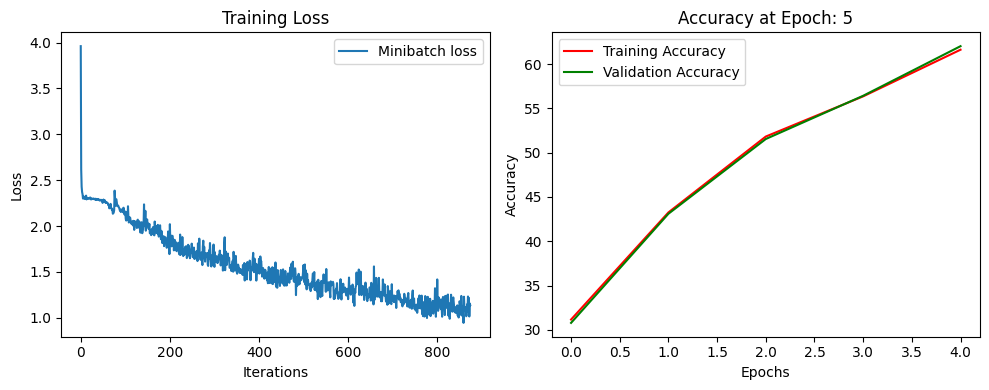

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 006/050 | Batch 0000/0175 | Loss: 1.1023
Epoch: 006/050 | Batch 0100/0175 | Loss: 1.1805
Epoch: 006/050 | Train: 69.47% | Validation: 68.68%
Epoch: 006/050 | Train Acc: 69.47% | Validation Acc: 68.68% | Precision: 0.6871 | Recall: 0.6872 | F1: 0.6826
Time elapsed: 6.03 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 007/050 | Batch 0000/0175 | Loss: 0.9040
Epoch: 007/050 | Batch 0100/0175 | Loss: 0.7415


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 007/050 | Train: 72.52% | Validation: 70.78%
Epoch: 007/050 | Train Acc: 72.52% | Validation Acc: 70.78% | Precision: 0.7128 | Recall: 0.7083 | F1: 0.7030
Time elapsed: 7.04 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 008/050 | Batch 0000/0175 | Loss: 0.8592
Epoch: 008/050 | Batch 0100/0175 | Loss: 0.7252


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 008/050 | Train: 73.64% | Validation: 73.14%
Epoch: 008/050 | Train Acc: 73.64% | Validation Acc: 73.14% | Precision: 0.7459 | Recall: 0.7309 | F1: 0.7274
Time elapsed: 8.03 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 009/050 | Batch 0000/0175 | Loss: 0.7126
Epoch: 009/050 | Batch 0100/0175 | Loss: 0.7056


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 009/050 | Train: 77.56% | Validation: 75.80%
Epoch: 009/050 | Train Acc: 77.56% | Validation Acc: 75.80% | Precision: 0.7740 | Recall: 0.7582 | F1: 0.7608
Time elapsed: 9.02 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 010/050 | Batch 0000/0175 | Loss: 0.6127
Epoch: 010/050 | Batch 0100/0175 | Loss: 0.6498


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 010/050 | Train: 81.74% | Validation: 79.40%
Epoch: 010/050 | Train Acc: 81.74% | Validation Acc: 79.40% | Precision: 0.7971 | Recall: 0.7944 | F1: 0.7946
Time elapsed: 10.02 min


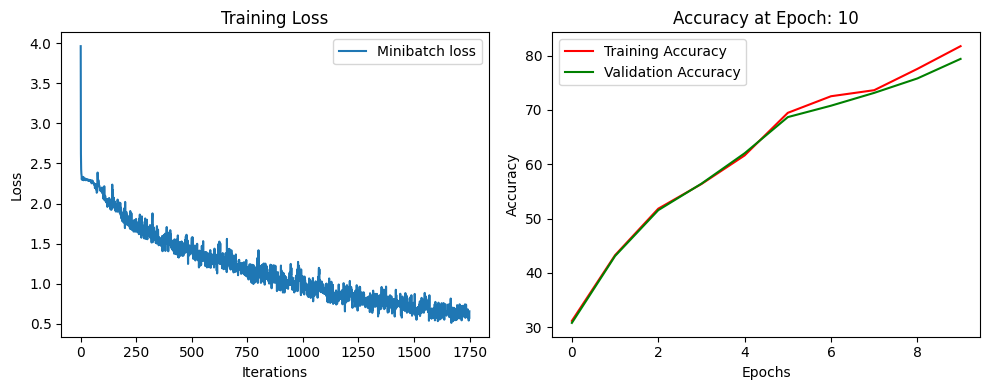

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 011/050 | Batch 0000/0175 | Loss: 0.4882
Epoch: 011/050 | Batch 0100/0175 | Loss: 0.5517
Epoch: 011/050 | Train: 80.51% | Validation: 77.02%
Epoch: 011/050 | Train Acc: 80.51% | Validation Acc: 77.02% | Precision: 0.7803 | Recall: 0.7715 | F1: 0.7680
Time elapsed: 11.08 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 012/050 | Batch 0000/0175 | Loss: 0.5763
Epoch: 012/050 | Batch 0100/0175 | Loss: 0.5527
Epoch: 012/050 | Train: 82.19% | Validation: 78.74%
Epoch: 012/050 | Train Acc: 82.19% | Validation Acc: 78.74% | Precision: 0.7982 | Recall: 0.7886 | F1: 0.7863
Time elapsed: 12.11 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 013/050 | Batch 0000/0175 | Loss: 0.5630
Epoch: 013/050 | Batch 0100/0175 | Loss: 0.4763


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 013/050 | Train: 81.87% | Validation: 77.44%
Epoch: 013/050 | Train Acc: 81.87% | Validation Acc: 77.44% | Precision: 0.7893 | Recall: 0.7754 | F1: 0.7721
Time elapsed: 13.12 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 014/050 | Batch 0000/0175 | Loss: 0.5646
Epoch: 014/050 | Batch 0100/0175 | Loss: 0.4592


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 014/050 | Train: 86.51% | Validation: 81.16%
Epoch: 014/050 | Train Acc: 86.51% | Validation Acc: 81.16% | Precision: 0.8170 | Recall: 0.8124 | F1: 0.8114
Time elapsed: 14.16 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 015/050 | Batch 0000/0175 | Loss: 0.3952
Epoch: 015/050 | Batch 0100/0175 | Loss: 0.4853


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 015/050 | Train: 87.93% | Validation: 81.04%
Epoch: 015/050 | Train Acc: 87.93% | Validation Acc: 81.04% | Precision: 0.8139 | Recall: 0.8110 | F1: 0.8087
Time elapsed: 15.17 min


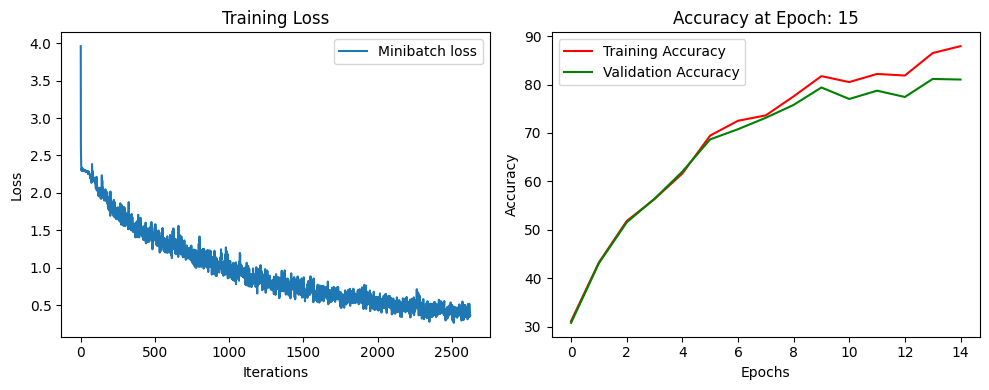

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 016/050 | Batch 0000/0175 | Loss: 0.3800
Epoch: 016/050 | Batch 0100/0175 | Loss: 0.2894


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 016/050 | Train: 90.28% | Validation: 82.60%
Epoch: 016/050 | Train Acc: 90.28% | Validation Acc: 82.60% | Precision: 0.8295 | Recall: 0.8258 | F1: 0.8264
Time elapsed: 16.20 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 017/050 | Batch 0000/0175 | Loss: 0.2924
Epoch: 017/050 | Batch 0100/0175 | Loss: 0.2841


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 017/050 | Train: 90.79% | Validation: 82.78%
Epoch: 017/050 | Train Acc: 90.79% | Validation Acc: 82.78% | Precision: 0.8327 | Recall: 0.8296 | F1: 0.8270
Time elapsed: 17.22 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 018/050 | Batch 0000/0175 | Loss: 0.2396
Epoch: 018/050 | Batch 0100/0175 | Loss: 0.3655


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 018/050 | Train: 91.58% | Validation: 82.26%
Epoch: 018/050 | Train Acc: 91.58% | Validation Acc: 82.26% | Precision: 0.8313 | Recall: 0.8218 | F1: 0.8233
Time elapsed: 18.24 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 019/050 | Batch 0000/0175 | Loss: 0.2098
Epoch: 019/050 | Batch 0100/0175 | Loss: 0.3097


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 019/050 | Train: 90.82% | Validation: 82.06%
Epoch: 019/050 | Train Acc: 90.82% | Validation Acc: 82.06% | Precision: 0.8223 | Recall: 0.8220 | F1: 0.8169
Time elapsed: 19.28 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 020/050 | Batch 0000/0175 | Loss: 0.3292
Epoch: 020/050 | Batch 0100/0175 | Loss: 0.2876


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 020/050 | Train: 92.30% | Validation: 83.08%
Epoch: 020/050 | Train Acc: 92.30% | Validation Acc: 83.08% | Precision: 0.8383 | Recall: 0.8312 | F1: 0.8301
Time elapsed: 20.29 min


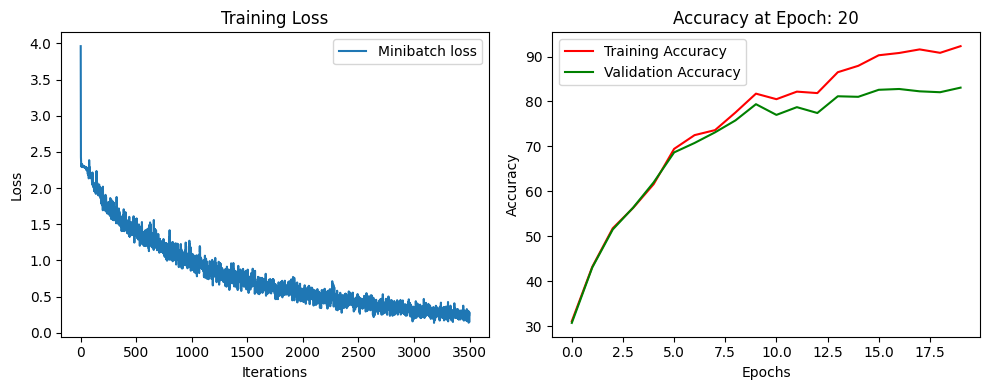

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 021/050 | Batch 0000/0175 | Loss: 0.1954
Epoch: 021/050 | Batch 0100/0175 | Loss: 0.2900


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 021/050 | Train: 95.33% | Validation: 84.00%
Epoch: 021/050 | Train Acc: 95.33% | Validation Acc: 84.00% | Precision: 0.8425 | Recall: 0.8402 | F1: 0.8403
Time elapsed: 21.32 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 022/050 | Batch 0000/0175 | Loss: 0.1007
Epoch: 022/050 | Batch 0100/0175 | Loss: 0.1928


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 022/050 | Train: 95.33% | Validation: 83.66%
Epoch: 022/050 | Train Acc: 95.33% | Validation Acc: 83.66% | Precision: 0.8369 | Recall: 0.8374 | F1: 0.8365
Time elapsed: 22.34 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 023/050 | Batch 0000/0175 | Loss: 0.1521
Epoch: 023/050 | Batch 0100/0175 | Loss: 0.1916


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 023/050 | Train: 94.56% | Validation: 82.78%
Epoch: 023/050 | Train Acc: 94.56% | Validation Acc: 82.78% | Precision: 0.8407 | Recall: 0.8279 | F1: 0.8315
Time elapsed: 23.36 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 024/050 | Batch 0000/0175 | Loss: 0.1930
Epoch: 024/050 | Batch 0100/0175 | Loss: 0.1634


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 024/050 | Train: 95.14% | Validation: 83.52%
Epoch: 024/050 | Train Acc: 95.14% | Validation Acc: 83.52% | Precision: 0.8379 | Recall: 0.8360 | F1: 0.8343
Time elapsed: 24.36 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 025/050 | Batch 0000/0175 | Loss: 0.1481
Epoch: 025/050 | Batch 0100/0175 | Loss: 0.2462


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 025/050 | Train: 95.94% | Validation: 83.04%
Epoch: 025/050 | Train Acc: 95.94% | Validation Acc: 83.04% | Precision: 0.8348 | Recall: 0.8312 | F1: 0.8303
Time elapsed: 25.37 min


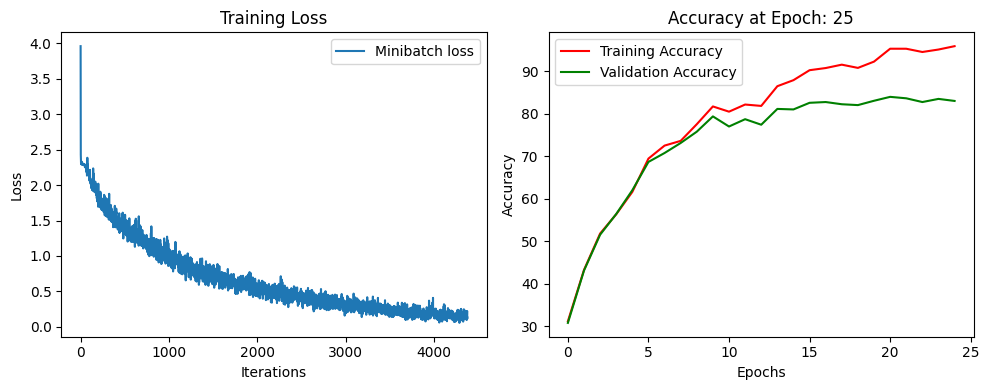

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 026/050 | Batch 0000/0175 | Loss: 0.1495
Epoch: 026/050 | Batch 0100/0175 | Loss: 0.1506


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 026/050 | Train: 96.72% | Validation: 83.88%
Epoch: 026/050 | Train Acc: 96.72% | Validation Acc: 83.88% | Precision: 0.8416 | Recall: 0.8389 | F1: 0.8388
Time elapsed: 26.42 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 027/050 | Batch 0000/0175 | Loss: 0.1237
Epoch: 027/050 | Batch 0100/0175 | Loss: 0.1024


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 027/050 | Train: 96.42% | Validation: 83.44%
Epoch: 027/050 | Train Acc: 96.42% | Validation Acc: 83.44% | Precision: 0.8396 | Recall: 0.8351 | F1: 0.8339
Time elapsed: 27.43 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 028/050 | Batch 0000/0175 | Loss: 0.1442
Epoch: 028/050 | Batch 0100/0175 | Loss: 0.1990


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 028/050 | Train: 97.35% | Validation: 84.04%
Epoch: 028/050 | Train Acc: 97.35% | Validation Acc: 84.04% | Precision: 0.8457 | Recall: 0.8410 | F1: 0.8409
Time elapsed: 28.44 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 029/050 | Batch 0000/0175 | Loss: 0.0809
Epoch: 029/050 | Batch 0100/0175 | Loss: 0.0760


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 029/050 | Train: 96.89% | Validation: 83.80%
Epoch: 029/050 | Train Acc: 96.89% | Validation Acc: 83.80% | Precision: 0.8438 | Recall: 0.8395 | F1: 0.8375
Time elapsed: 29.46 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 030/050 | Batch 0000/0175 | Loss: 0.0996
Epoch: 030/050 | Batch 0100/0175 | Loss: 0.0800


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 030/050 | Train: 98.25% | Validation: 84.54%
Epoch: 030/050 | Train Acc: 98.25% | Validation Acc: 84.54% | Precision: 0.8499 | Recall: 0.8452 | F1: 0.8463
Time elapsed: 30.48 min


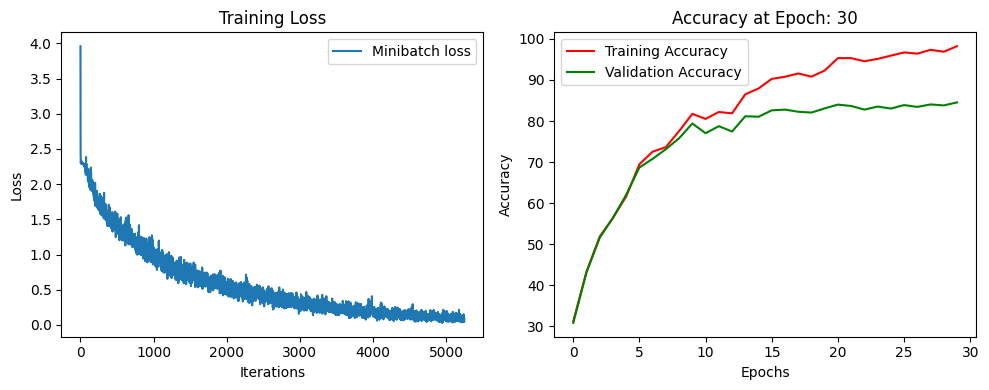

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 031/050 | Batch 0000/0175 | Loss: 0.0237
Epoch: 031/050 | Batch 0100/0175 | Loss: 0.1234


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 031/050 | Train: 96.77% | Validation: 83.80%
Epoch: 031/050 | Train Acc: 96.77% | Validation Acc: 83.80% | Precision: 0.8388 | Recall: 0.8383 | F1: 0.8361
Time elapsed: 31.50 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 032/050 | Batch 0000/0175 | Loss: 0.1152
Epoch: 032/050 | Batch 0100/0175 | Loss: 0.0979


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 032/050 | Train: 98.45% | Validation: 84.80%
Epoch: 032/050 | Train Acc: 98.45% | Validation Acc: 84.80% | Precision: 0.8514 | Recall: 0.8478 | F1: 0.8487
Time elapsed: 32.50 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 033/050 | Batch 0000/0175 | Loss: 0.0503
Epoch: 033/050 | Batch 0100/0175 | Loss: 0.0582
Epoch: 033/050 | Train: 97.74% | Validation: 84.14%
Epoch: 033/050 | Train Acc: 97.74% | Validation Acc: 84.14% | Precision: 0.8474 | Recall: 0.8409 | F1: 0.8424
Time elapsed: 33.52 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 034/050 | Batch 0000/0175 | Loss: 0.0672
Epoch: 034/050 | Batch 0100/0175 | Loss: 0.0822


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 034/050 | Train: 98.37% | Validation: 84.70%
Epoch: 034/050 | Train Acc: 98.37% | Validation Acc: 84.70% | Precision: 0.8469 | Recall: 0.8475 | F1: 0.8465
Time elapsed: 34.52 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 035/050 | Batch 0000/0175 | Loss: 0.0301
Epoch: 035/050 | Batch 0100/0175 | Loss: 0.0859


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 035/050 | Train: 98.57% | Validation: 85.24%
Epoch: 035/050 | Train Acc: 98.57% | Validation Acc: 85.24% | Precision: 0.8603 | Recall: 0.8531 | F1: 0.8543
Time elapsed: 35.53 min


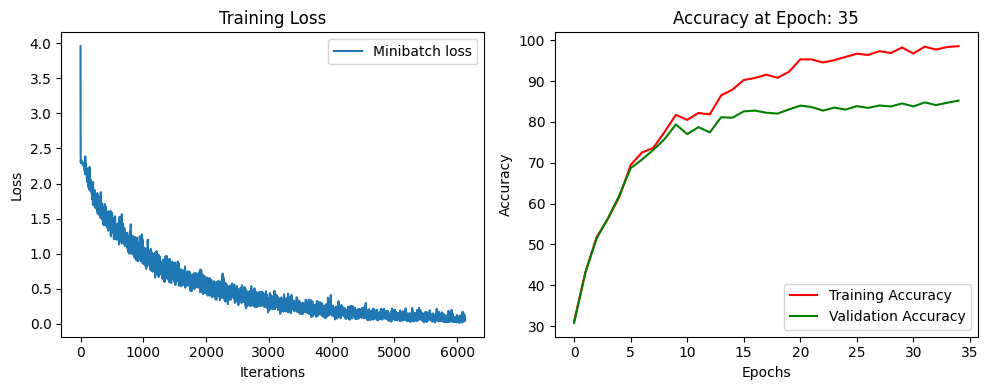

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 036/050 | Batch 0000/0175 | Loss: 0.0374
Epoch: 036/050 | Batch 0100/0175 | Loss: 0.0934


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 036/050 | Train: 98.34% | Validation: 84.14%
Epoch: 036/050 | Train Acc: 98.34% | Validation Acc: 84.14% | Precision: 0.8452 | Recall: 0.8414 | F1: 0.8424
Time elapsed: 36.55 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 037/050 | Batch 0000/0175 | Loss: 0.0510
Epoch: 037/050 | Batch 0100/0175 | Loss: 0.0535


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 037/050 | Train: 98.90% | Validation: 84.48%
Epoch: 037/050 | Train Acc: 98.90% | Validation Acc: 84.48% | Precision: 0.8473 | Recall: 0.8452 | F1: 0.8449
Time elapsed: 37.56 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 038/050 | Batch 0000/0175 | Loss: 0.0318
Epoch: 038/050 | Batch 0100/0175 | Loss: 0.0933


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 038/050 | Train: 98.56% | Validation: 84.48%
Epoch: 038/050 | Train Acc: 98.56% | Validation Acc: 84.48% | Precision: 0.8451 | Recall: 0.8457 | F1: 0.8438
Time elapsed: 38.58 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 039/050 | Batch 0000/0175 | Loss: 0.0524
Epoch: 039/050 | Batch 0100/0175 | Loss: 0.0422


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 039/050 | Train: 98.31% | Validation: 84.26%
Epoch: 039/050 | Train Acc: 98.31% | Validation Acc: 84.26% | Precision: 0.8501 | Recall: 0.8434 | F1: 0.8445
Time elapsed: 39.59 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 040/050 | Batch 0000/0175 | Loss: 0.0568
Epoch: 040/050 | Batch 0100/0175 | Loss: 0.0195


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 040/050 | Train: 98.98% | Validation: 84.84%
Epoch: 040/050 | Train Acc: 98.98% | Validation Acc: 84.84% | Precision: 0.8503 | Recall: 0.8491 | F1: 0.8488
Time elapsed: 40.64 min


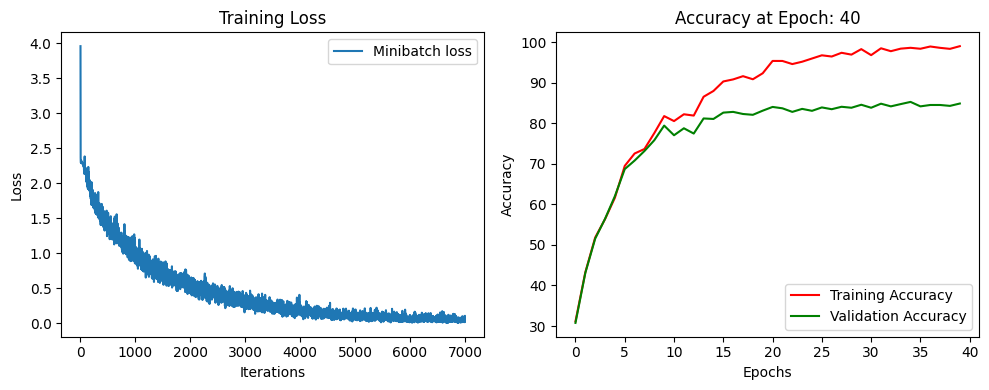

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 041/050 | Batch 0000/0175 | Loss: 0.0300
Epoch: 041/050 | Batch 0100/0175 | Loss: 0.0163


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 041/050 | Train: 98.94% | Validation: 84.84%
Epoch: 041/050 | Train Acc: 98.94% | Validation Acc: 84.84% | Precision: 0.8505 | Recall: 0.8489 | F1: 0.8491
Time elapsed: 41.67 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 042/050 | Batch 0000/0175 | Loss: 0.0317
Epoch: 042/050 | Batch 0100/0175 | Loss: 0.0568


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 042/050 | Train: 98.87% | Validation: 84.06%
Epoch: 042/050 | Train Acc: 98.87% | Validation Acc: 84.06% | Precision: 0.8451 | Recall: 0.8408 | F1: 0.8409
Time elapsed: 42.71 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 043/050 | Batch 0000/0175 | Loss: 0.0342
Epoch: 043/050 | Batch 0100/0175 | Loss: 0.0833


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 043/050 | Train: 99.10% | Validation: 84.76%
Epoch: 043/050 | Train Acc: 99.10% | Validation Acc: 84.76% | Precision: 0.8510 | Recall: 0.8478 | F1: 0.8487
Time elapsed: 43.74 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 044/050 | Batch 0000/0175 | Loss: 0.0455
Epoch: 044/050 | Batch 0100/0175 | Loss: 0.0486


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 044/050 | Train: 98.48% | Validation: 84.38%
Epoch: 044/050 | Train Acc: 98.48% | Validation Acc: 84.38% | Precision: 0.8457 | Recall: 0.8440 | F1: 0.8428
Time elapsed: 44.77 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 045/050 | Batch 0000/0175 | Loss: 0.1226
Epoch: 045/050 | Batch 0100/0175 | Loss: 0.0352


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 045/050 | Train: 98.55% | Validation: 84.76%
Epoch: 045/050 | Train Acc: 98.55% | Validation Acc: 84.76% | Precision: 0.8504 | Recall: 0.8479 | F1: 0.8485
Time elapsed: 45.83 min


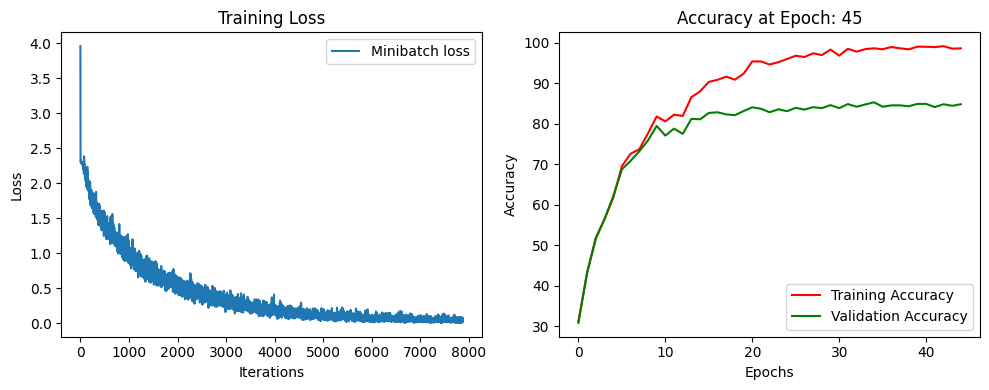

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 046/050 | Batch 0000/0175 | Loss: 0.0308
Epoch: 046/050 | Batch 0100/0175 | Loss: 0.0368


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 046/050 | Train: 99.14% | Validation: 85.36%
Epoch: 046/050 | Train Acc: 99.14% | Validation Acc: 85.36% | Precision: 0.8550 | Recall: 0.8548 | F1: 0.8537
Time elapsed: 46.86 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 047/050 | Batch 0000/0175 | Loss: 0.0360
Epoch: 047/050 | Batch 0100/0175 | Loss: 0.0099


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 047/050 | Train: 98.67% | Validation: 84.64%
Epoch: 047/050 | Train Acc: 98.67% | Validation Acc: 84.64% | Precision: 0.8528 | Recall: 0.8455 | F1: 0.8468
Time elapsed: 47.88 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 048/050 | Batch 0000/0175 | Loss: 0.0269
Epoch: 048/050 | Batch 0100/0175 | Loss: 0.0224


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 048/050 | Train: 98.69% | Validation: 84.52%
Epoch: 048/050 | Train Acc: 98.69% | Validation Acc: 84.52% | Precision: 0.8452 | Recall: 0.8457 | F1: 0.8435
Time elapsed: 48.92 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 049/050 | Batch 0000/0175 | Loss: 0.0936
Epoch: 049/050 | Batch 0100/0175 | Loss: 0.0413


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 049/050 | Train: 99.04% | Validation: 85.34%
Epoch: 049/050 | Train Acc: 99.04% | Validation Acc: 85.34% | Precision: 0.8621 | Recall: 0.8539 | F1: 0.8549
Time elapsed: 49.93 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 050/050 | Batch 0000/0175 | Loss: 0.0175
Epoch: 050/050 | Batch 0100/0175 | Loss: 0.0149


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 050/050 | Train: 99.32% | Validation: 85.94%
Epoch: 050/050 | Train Acc: 99.32% | Validation Acc: 85.94% | Precision: 0.8639 | Recall: 0.8597 | F1: 0.8603
Time elapsed: 50.94 min


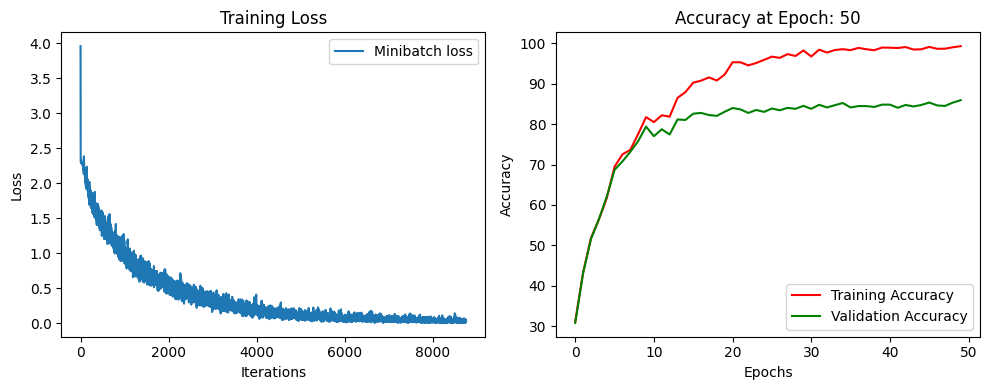

Total Training Time: 50.95 min
Validation Precision over epochs: [0.2680286577446059, 0.43861100711723144, 0.5126819015603509, 0.5961347730003393, 0.6379319723261555, 0.6870693821574896, 0.7127899622323006, 0.7459355161211096, 0.7740188739212042, 0.7971247084167258, 0.7803306302871282, 0.7982109807015635, 0.7892609510008299, 0.8170267998222321, 0.8138909190996977, 0.8294828268190869, 0.8327044242671185, 0.8312829954852015, 0.8222569662275847, 0.8382818330088098, 0.8424674458217428, 0.8369313734536258, 0.8406868214451506, 0.8378930693057033, 0.8348479444989451, 0.8416137715349713, 0.8395733608606987, 0.8457192540804158, 0.8438240588070298, 0.8499105150577233, 0.8387923451800381, 0.8513870616861992, 0.8473881635069006, 0.8468544098383639, 0.8602867519358399, 0.8451735820944881, 0.847254804203929, 0.8451397448761266, 0.8501421808303562, 0.8503072280648473, 0.8505369636684478, 0.8450817408529012, 0.8509998023240314, 0.8456656302316073, 0.8504456998856457, 0.8549730034860443, 0.852807507010

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test accuracy 84.35%


NameError: name 'precision_list' is not defined

In [12]:
model = VGG16(num_classes=10)
model = model.to(DEVICE)



optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)
minibatch_loss_list, train_acc_list, valid_acc_list, valid_precision_list, valid_recall_list, valid_f1_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)



plot_all_metrics(minibatch_loss_list, train_acc_list, valid_acc_list, precision_list, recall_list, f1_list)


print("Validation Precision over epochs: after training", valid_precision_list)
print("Validation Recall over epochs: after training", valid_recall_list)
print("Validation F1 Score over epochs: after training", valid_f1_list)


plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [13]:
import pandas as pd


results_dir = '/content/drive/My Drive/Colab Notebooks/II142X-Results'

def save_results_to_csv(results_dir, minibatch_loss_list, train_acc_list, valid_acc_list, valid_precision_list, valid_recall_list, valid_f1_list):
    results_df = pd.DataFrame({
        'Minibatch Loss': minibatch_loss_list,
        'Training Accuracy': train_acc_list,
        'Validation Accuracy': valid_acc_list,
        'Validation Precision': valid_precision_list,
        'Validation Recall': valid_recall_list,
        'Validation F1 Score': valid_f1_list
    })
    results_path = os.path.join(results_dir, 'training_results.csv')
    results_df.to_csv(results_path, index=False)
    print(f'Results saved to {results_path}')

# At the end of your train_model function:
save_results_to_csv(results_dir, minibatch_loss_list, train_acc_list, valid_acc_list, valid_precision_list, valid_recall_list, valid_f1_list)


ValueError: All arrays must be of the same length

In [ ]:
results_dir = '/content/drive/My Drive/Colab Notebooks/II142X-Results'

import os

if not os.path.exists(results_dir):
    os.makedirs(results_dir)


plot_all_metrics( minibatch_loss_list = minibatch_loss_list,
                 train_acc_list = train_acc_list,
                 valid_acc_list = valid_acc_list,
                 precision_list = valid_precision_list,
                 recall_list = valid_recall_list,
                 f1_list = valid_f1_list,
                 num_epochs = NUM_EPOCHS,
                 iter_per_epoch=len(train_loader),
                 model_used = '16',
                 results_dir = results_dir
                 )

# mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
# plot_confusion_matrix(mat, class_names=class_dict.values())
# plt.show()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 001/050 | Batch 0000/0175 | Loss: 2.6783
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.0376


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 001/050 | Train: 29.28% | Validation: 28.86%
Epoch: 001/050 | Train Acc: 29.28% | Validation Acc: 28.86% | Precision: 0.2434 | Recall: 0.2894 | F1: 0.2422
Time elapsed: 2.62 min


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 002/050 | Batch 0000/0175 | Loss: 1.8338
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.7213


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 002/050 | Train: 38.55% | Validation: 38.76%
Epoch: 002/050 | Train Acc: 38.55% | Validation Acc: 38.76% | Precision: 0.4254 | Recall: 0.3842 | F1: 0.3511
Time elapsed: 5.25 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 003/050 | Batch 0000/0175 | Loss: 1.6612
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.5142


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 003/050 | Train: 43.75% | Validation: 43.44%
Epoch: 003/050 | Train Acc: 43.75% | Validation Acc: 43.44% | Precision: 0.4806 | Recall: 0.4366 | F1: 0.4025
Time elapsed: 7.88 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 004/050 | Batch 0000/0175 | Loss: 1.6076
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.3707


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 004/050 | Train: 55.05% | Validation: 55.32%
Epoch: 004/050 | Train Acc: 55.05% | Validation Acc: 55.32% | Precision: 0.5723 | Recall: 0.5506 | F1: 0.5420
Time elapsed: 10.53 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 005/050 | Batch 0000/0175 | Loss: 1.1274
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.2034


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 005/050 | Train: 60.91% | Validation: 61.16%
Epoch: 005/050 | Train Acc: 60.91% | Validation Acc: 61.16% | Precision: 0.6347 | Recall: 0.6099 | F1: 0.6029
Time elapsed: 13.17 min


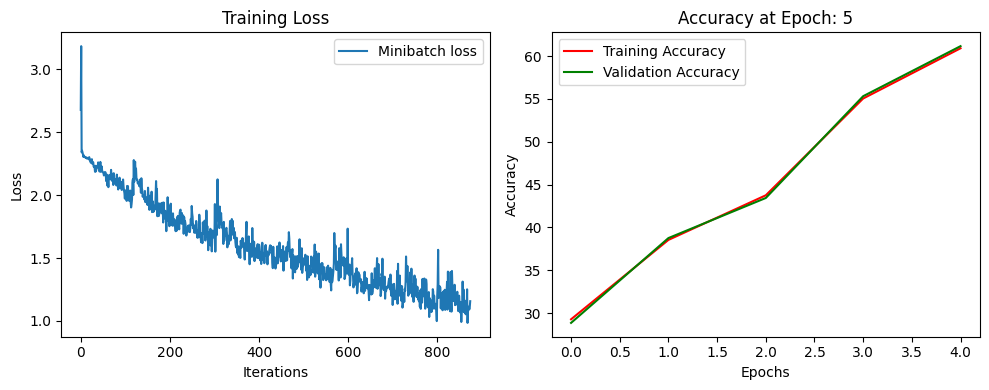

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 006/050 | Batch 0000/0175 | Loss: 0.9863
Epoch: 006/050 | Batch 0100/0175 | Loss: 0.9772


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 006/050 | Train: 66.86% | Validation: 65.90%
Epoch: 006/050 | Train Acc: 66.86% | Validation Acc: 65.90% | Precision: 0.6656 | Recall: 0.6602 | F1: 0.6442
Time elapsed: 15.83 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 007/050 | Batch 0000/0175 | Loss: 1.0262
Epoch: 007/050 | Batch 0100/0175 | Loss: 0.9443


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 007/050 | Train: 70.27% | Validation: 68.80%
Epoch: 007/050 | Train Acc: 70.27% | Validation Acc: 68.80% | Precision: 0.7070 | Recall: 0.6886 | F1: 0.6843
Time elapsed: 18.50 min


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 008/050 | Batch 0000/0175 | Loss: 0.8624


In [ ]:
model = VGG23_128(num_classes=10)
model = model.to(DEVICE)



optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list_128, train_acc_list_128, valid_acc_list_128, valid_precision_list_128, valid_recall_list_128, valid_f1_list_128= train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_128,
    valid_loader=valid_loader_128,
    test_loader=test_loader_128,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)



In [ ]:
plot_all_metrics( minibatch_loss_list = minibatch_loss_list_128,
                 train_acc_list = train_acc_list_128,
                 valid_acc_list = valid_acc_list_128,
                 precision_list = valid_precision_list_128,
                 recall_list = valid_recall_list_128,
                 f1_list = valid_f1_list_128,
                 num_epochs = NUM_EPOCHS,
                 iter_per_epoch=len(train_loader),
                 results_dir = results_dir,
                  model = 23
                 )


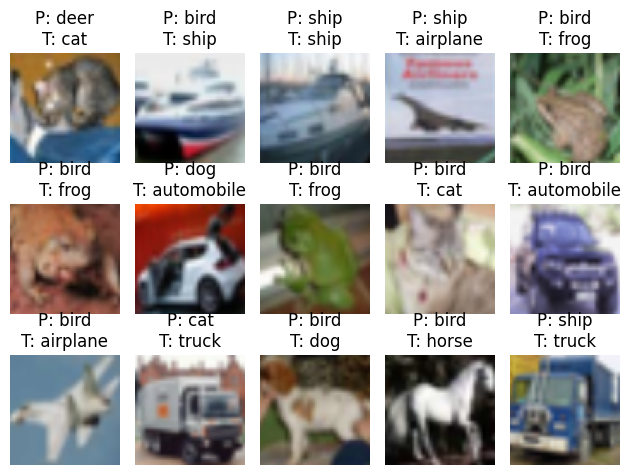

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)



In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader_128, unnormalizer=unnormalizer, class_dict=class_dict)

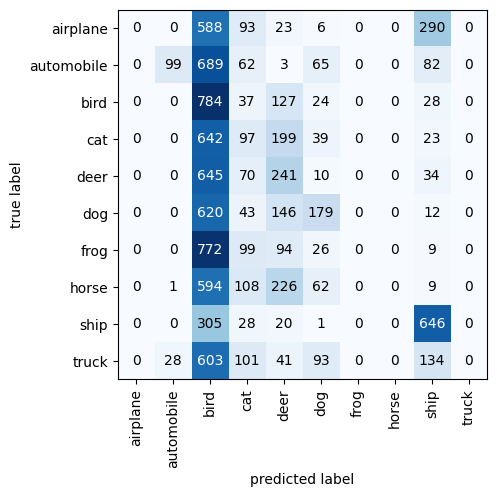

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

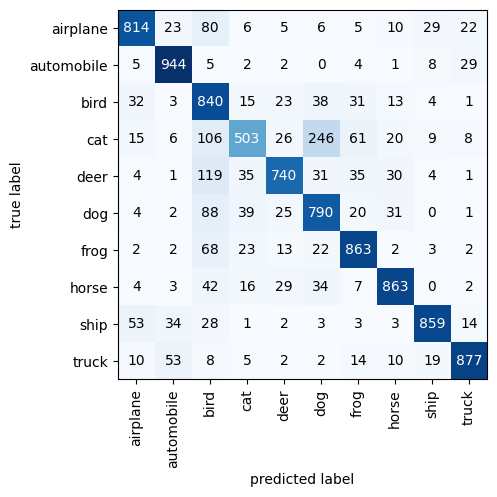

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader_128, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()